# Advancing Landslide Risk Management: Integrating Prediction Models and Remote Sensing Data

<img src="https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/thumbnails/image/BigSur1_May20SlideDES_0.jpg" width=800 height=600 />
USGS air photo of the Mud Creek landslide, taken on May 27, 2017

Introducing a dual model system to predict and locate landslides could significantly enhance our ability to manage their impacts. By integrating predictive modeling techniques with real-time monitoring systems, this approach offers both proactive and reactive capabilities. The predictive model, a modified Antecedent Water Index model, which we call A*, employs extreme values of modeled soil water to anticipate landslide-inducing rainfall, enhancing prediction accuracy. Once A* has determined where landslides are predicted we can then utilize NASA's OPREA Land Surface Disturbance Alert model to  detect and pinpoint landslide occurrences in near real-time. This dual model system has the potential to greatly improve landslide risk management strategies and contribute to community safety and resilience. 

Here's an overview of how the data is processed in this system:

1. **Predictive Model**: We use a method to forecast potential landslides by analyzing soil moisture levels and rainfall patterns. Think of it like a sophisticated weather forecast that tells us when and where landslides might happen.

2. **Real-Time Monitoring**: We have a system in place that constantly watches for signs of landslides using various sources of information. This allows us to quickly identify and respond to any landslides as they occur.

3. **Vegetation and Land Changes**: We also monitor changes in the land and vegetation using high-resolution satellite images from the Landsat and Sentinel-2 satellites. These images help us spot disturbances in the environment, which can be early warning signs of landslides.

4. **Data Integration**: By combining predictions, real-time monitoring, and satellite data, we create a comprehensive view of landslide risks. This integrated approach allows us to take both preventive measures and immediate actions when needed.

5. **Proof of Concept and Automation**: We are testing this system with data from 2023-2024 to prove its effectiveness. The goal is to automate these processes for future use, making it easier to manage landslide risks continuously.

This system aims to provide timely warnings, improve response strategies, and ultimately enhance the safety and resilience of communities vulnerable to landslides.


Perkins, J. P., Oakley, N. S., Collins, B. D., Corbett, S. C., and Burgess, W. P.: Characterizing the scale of regional landslide triggering from storm hydrometeorology, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2024-873, 2024.

OPERA Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 product V001 – OPERA_L3_DIST-ALERT-HLS_V1 Hansen, M.. OPERA Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 product (Version 1). 2024, distributed by NASA EOSDIS Land Processes Distributed Active Archive Center, https://doi.org/10.5067/SNWG/OPERA_L3_DIST-ALERT-HLS_V1.001.

### Below is a flow chart exhiting the rought idea of how the workflow should progress: 
________________________________________________________________________________________
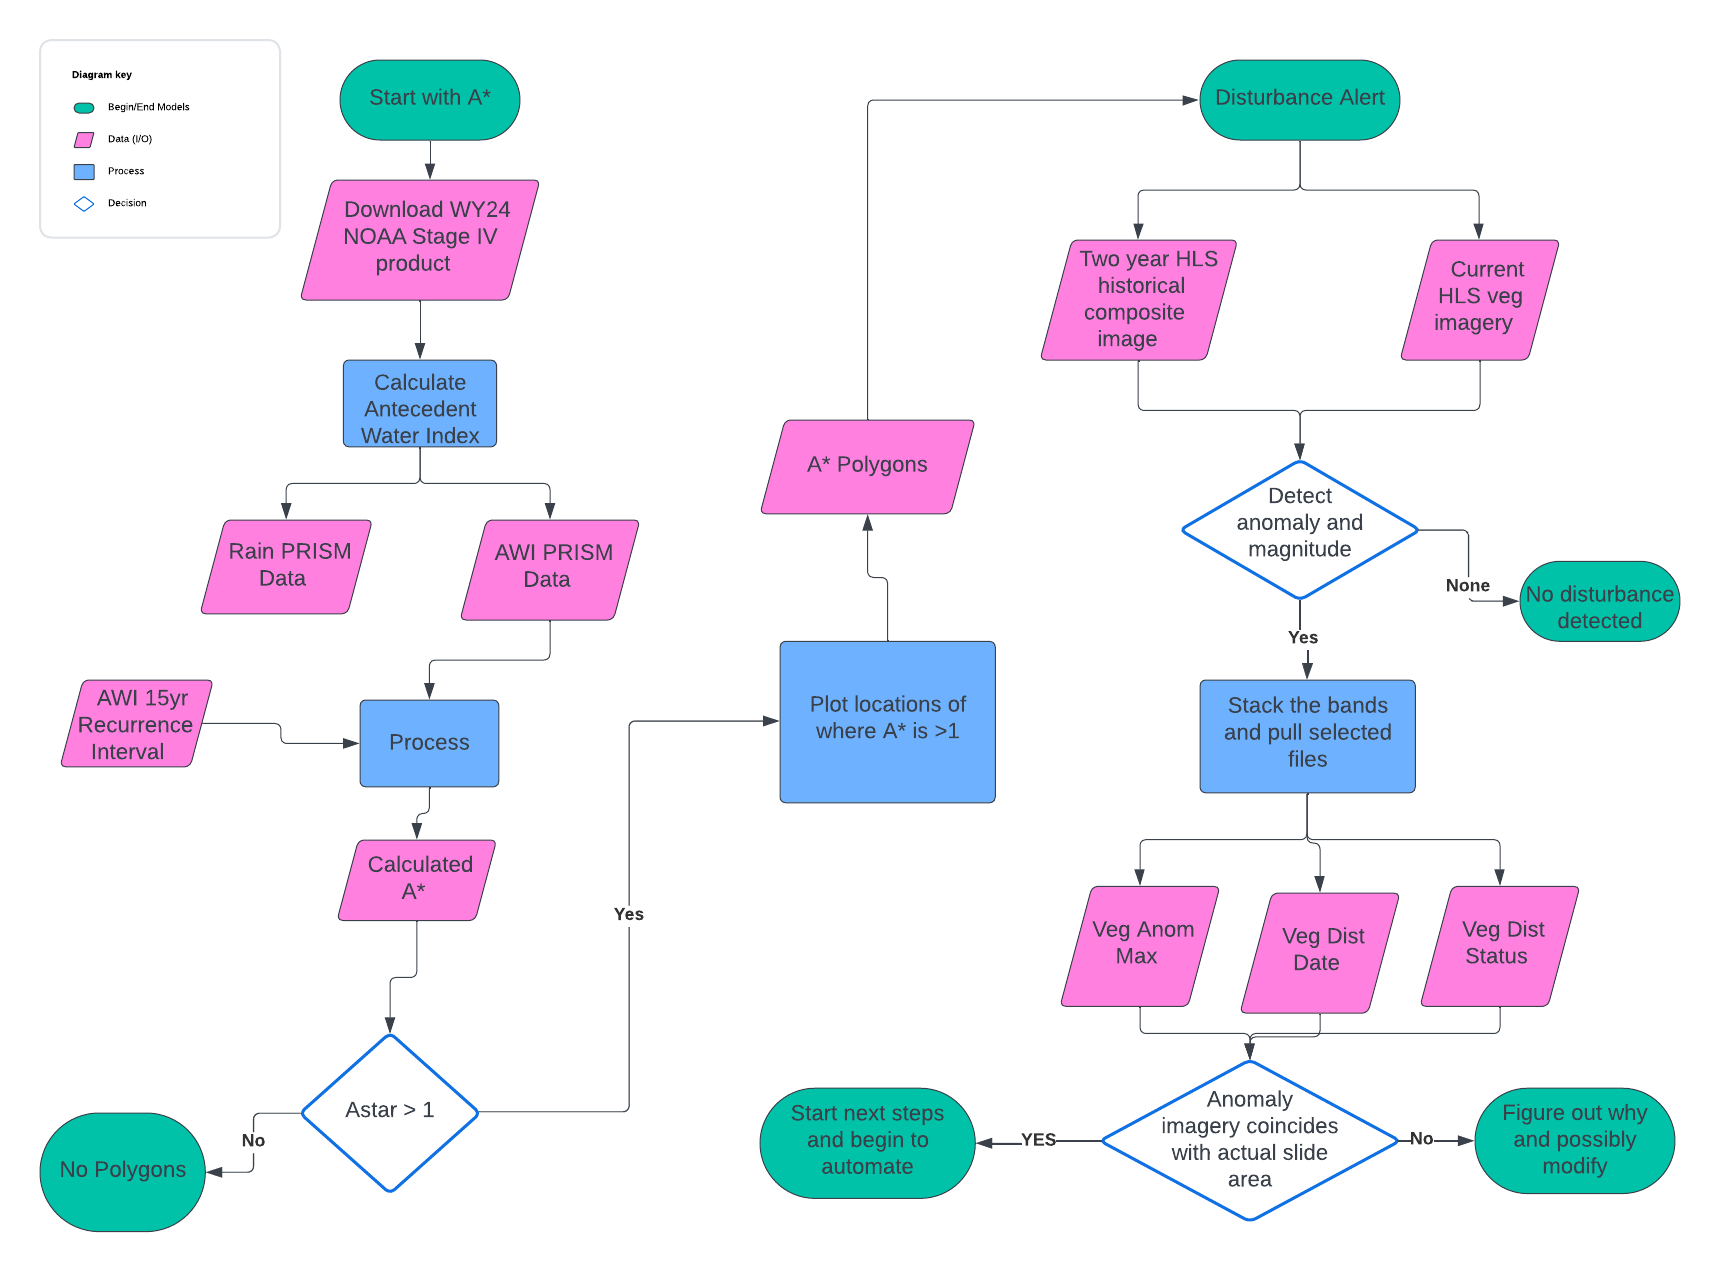

# A* Methodology 

The prediction model, A*—modified from the Antecedent Water Index model, employs extreme values of modeled soil water relative to local climatology as a proxy for landslide-inducing rainfall. This type of model falls within the category of reduced-complexity soil hydrologic models, commonly referred to as 'leaky barrel' or 'tank' models, where rainfall rapidly enters the model reservoir and drains proportionally to reservoir height. A regional landslide-triggering proxy is then calibrated based on anomalous values of theoretical soil water, leveraging the Antecedent Water Index by Godt et al. (2006) and research by Wilson and Wieczorek (1995), termed A*. This refined approach enhances landslide prediction by considering deviations in soil moisture levels.

In [1]:
# Import needed libaries 

import earthaccess
import numpy as np
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import numpy as np
from osgeo import gdal
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import rasterio 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time
# from scipy.signal import find_peaks
# import scipy.signal as signal
import pygmt
import os

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.dpi'] = 300 # nicer inline figures...

# # Study Domain
min_lon = 235-360.
max_lon = 247-360.
min_lat = 32.
max_lat = 43.


## Below are the routines to get AWI from the rainfall data downloaded from the NOAA CNRFC (six-hourly netcdfs)

In [2]:
# This script is used to process an individual rainfall file, which gets called in the other "process_dir" routine. The files
# are in a strange projection and need a custom projection string that we need to assign to the file in order to reproject 
# to lat-lon (WGS84 --> EPSG:4326). To make things more annoying, they switched the way they did this in 2021, so there are
# two versions of the routine: one for pre-september 2020 and one for post september 2020. 

def process_file_CNRFC(filepath,year): 
    import numpy as np
    import xarray as xr
    import rasterio
    import rioxarray 
        # Read in coordinate .csv file
    import pandas as pd
    
    
    ds = xr.open_dataset(filepath, decode_times=False, decode_coords="all")
    ds = ds.squeeze()
    
    ## Project dataset #####
    
    # Define projection. if date > Sept 30th, 2020 18z, then we have to use updated projection and lat/lon coords
    
    if year >= 2021:
        crs = rasterio.crs.CRS.from_proj4('+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +k=1 +x_0=2202656.25 +y_0=6515100 +a=6371200 +b=6371200 +to_meter=4762.5 +no_defs')
        df=pd.read_csv('C:/Users/skcor/JPerkins_Astar/QPE_latlons_new.csv', sep=',')
         # Make grid vectors from csv
        forlatvec = df.loc[df['Grid x'] == 0]
        latvec = forlatvec['Grid y']
        latvec = latvec.values
        forlonvec = df.loc[df['Grid y'] ==0 ]
        lonvec = forlonvec['Grid x']
        lonvec = lonvec.values
        # Assign coordinates to dataset
        ds = ds.rename_dims(dimx="longitude", dimy="latitude")
        ds = ds.assign_coords(longitude=("longitude", lonvec), latitude=("latitude", latvec))
        
        # While the earlier versions appeared to be in mm, these are in inches
        
        from metpy.units import units
        
        rain = ds['qpe_grid']
        rain = rain.metpy.convert_units('m')

    # For older datasets, we use a different reprojection...
    
    else:
        crs = rasterio.crs.CRS.from_proj4('+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +k=1 +x_0=2466975 +y_0=6534150 +a=6371200 +b=6371200 +to_meter=4762.5 +no_defs')
        # Note: this is just for older (pre-2019) files!! Must download other grid and use different proj.4 for post-2019 data
        df=pd.read_csv('C:/Users/skcor/JPerkins_Astar/QPE_latlons_old.csv', sep=',')
         # Make grid vectors from csv
        forlatvec = df.loc[df['Grid x'] == 0]
        latvec = forlatvec['Grid y']
        latvec = latvec.values
        forlonvec = df.loc[df['Grid y'] ==0 ]
        lonvec = forlonvec['Grid x']
        lonvec = lonvec.values
        # Assign coordinates to dataset
        ds = ds.rename_dims(x="longitude", y="latitude")
        ds = ds.assign_coords(longitude=("longitude", lonvec), latitude=("latitude", latvec))
        rain = ds['tp']
        rain = rain/1000 # Convert from [mm] to [m]
    
    # Assign definition projection from CNRFC (polar stereographic [above] ) 
    rain.rio.write_crs(crs, inplace=True)
    
    # Project data to WGS84 lat/lon
    rain_lonlat = rain.rio.reproject("EPSG:4326")

    # This section takes snippets of the precip file name and uses them for a new file name
    hour = filepath[-7:-5]
    day = filepath[-10:-8]
    month = filepath[-12:-10]
    year = filepath[-16:-12]
    
    date = year + "-" + month + "-" + day + "T" + hour + ":00"

    rtime = np.datetime64(date)
    
    # add to array
    rain_lonlat = rain_lonlat.assign_coords({"time": rtime})
    
    return rain_lonlat

In [3]:
## This routine will run through a directory of rainfall files for a given water year (start: Oct 1st) using the "process_file"
# routine above. The "year" parameter just corresponds to whether you need to use the older or newer (post-september 2020)
# reprojection method. The "WY" (water year) parameter is just a number you can put that appends it to the output file name. 

def process_dir_CNRFC_AWI_WY(filepath, min_lon, max_lon, min_lat, max_lat, year, WY):
    
    import glob
    import numpy as np
    import xarray as xr 
    from metpy.units import units    
    import rioxarray
    import rasterio
    # from tqdm.notebook import tqdm, trange
    import time

    # Make a list of filepaths corresponding to each file in the directory 
    
    filenames = glob.glob(filepath)
    
    # Sort the filenames alphabetically
    filenames = sorted(filenames)
    
     # Get raster information from first file to make empty arrays
    rain = process_file_CNRFC(filenames[1], year)
    
    # Mask the raster from the nan values
    rain = rain.where(rain < 1.0e38)
    
    # Clip raster to box coordinates. We have to do this for each file in the directory, but here we do this to determine
    # the size of the AWI grids 
    rain = rain.rio.write_crs(4326)
    rain = rain.rio.clip_box(minx = min_lon, miny = min_lat, maxx = max_lon, maxy = max_lat)

    # Make empty xarray files to put all rainfall data (and calculated AWI) into a single netcdf
    rainPrism = xr.DataArray()
    AWI_prism = xr.DataArray() 
    
    # Make an initial AWI array for model
    AWI_old = xr.zeros_like(rain)
    

    ############ ASSIGN PARAMETERS FOR AWI MODEL ###########
    
    AWI_old[:] = -0.18 # Initial conditions for AWI, somewhere between field capacity and theta_r. NOTE: MAKE SURE CONSISTENT WITH LSI PARAMETERS. 
      # Needs to be internally consistent! 
      # In this case, theta_fc = 0.22, this is reasonable late-season water content (see BALT sites for example). AWI_used = -0.18
      # this is the value of the "reservoir" for the leaky tank model. In other words, for each pixel, if the total rainfall is
      # less than 0.18 meters, the tank is still filling to its baseline. Once the cumulative rainfall exceeds this value, 
      # the AWI mass balance starts operating 
    
    # Define the time window for AWI calculation
    dt_hrs = 6.
    
    #################### Run through each file in the directory, add new rainfall data to cumulative rainfall prism, 
    #################### and calculate AWI for each time step
    # for file in tqdm(filenames, desc='files'):
    
    for file in filenames:
#         print("Processing",file)
        rain = process_file_CNRFC(file, year)
        # Clip raster to box coordinates
        rain = rain.where(rain < 1.0e5)
        rain = rain.rio.write_crs(4326)
#         rain = rain['tp']
        rain = rain.rio.clip_box(minx = min_lon, miny = min_lat, maxx = max_lon, maxy = max_lat)
#         rainSum = rainSum + rain
#         rainPeak = xr.where(rain>rainPeak, rain, rainPeak) # update array if a higher peak comes along
        rainPrism = xr.concat([rainPrism, rain],'z')
        
        ## Calculate AWI for current rain file
        
        AWI_new = AWI_run_one_step(AWI_old,rain,dt_hrs)
        AWI_new['time'] = rain['time'] # makes sure the timestamps match
        AWI_prism = xr.concat([AWI_prism,AWI_new],'z') # appends current AWI to AWI master file
        
        AWI_old = AWI_new
        time.sleep(0.01)
    
    # renames x and y to lat-lon
    rainPrism = rainPrism.rename({'x':'longitude','y':'latitude'})  
    AWI_prism = AWI_prism.rename({'x':'longitude','y':'latitude'})
    
    # generates output file names
    outfile1 = "rain_prism_" + WY + ".nc"
    outfile2 = "AWI_prism_" + WY + ".nc" 
    
    rainPrism.to_netcdf('C:/Users/skcor/JPerkins_Astar/ProcessingResults/' + outfile1)
    AWI_prism.to_netcdf('C:/Users/skcor/JPerkins_Astar/ProcessingResults/' + outfile2)
    
    print("Files exported")

    return rainPrism, AWI_prism


In [4]:
# This is the AWI calculation code 

def AWI_run_one_step(AWI_t_minus_dt, rain_m, dt_hrs):

    import numpy as np
    import xarray as xr
    # from tqdm.notebook import tqdm, trange
    import time
    
    # Define constants: 
    kd = 0.01 # drainage proportionality constant from Godt et al., 2006; [1/hrs]
#     field_capacity = 0.18 
    Ii_m_hr = rain_m/dt_hrs
    
    # AWI has two different modes. If it's dry enough, you just add rain to the barrel (first equation), but if the pixel has water in excess
    # of the field capacity then it fills and drains using the second equation
    AWI_addrain = AWI_t_minus_dt + rain_m # first equation, just add rain
    AWI_addrain_decay = AWI_t_minus_dt*np.exp(-kd*dt_hrs) + ((Ii_m_hr/kd)*(1.-np.exp(-kd*dt_hrs))) # fill and drain mass balance
    
    # This is perhaps inefficient, but I calculate both equations for all pixels above, then apply the correct equation according
    # to the conditions below. Note: the "where" command keeps the parts of the raster consistent with the first condition
    
#     AWI_t = AWI_addrain_decay.where(AWI_t_minus_dt>field_capacity,AWI_addrain)
            
    AWI_t = AWI_t_minus_dt.where(AWI_t_minus_dt >= 0, AWI_addrain)
    AWI_t = AWI_t.where(AWI_t < 0, AWI_addrain_decay)

    return AWI_t

## Here is a workflow to calculate AWI for an entire water year, and then use the 15-year recurrence AWI raster to then calculate A*

In [5]:
# Note: run all cells for the routines below before running this cell 

# Define the folder and path where the storm data live
filepath = os.path.join('C:/Users/skcor/JPerkins_Astar/WY2023/',"*.nc")
# so in this case the directory WY23 contains all the rainfall files for that water year

# # Calculate storm totals 
year = 2023 # flags whether to use updated CNRFC reference frame after 2020 (double-check NOAA CNRFC site...only applies to storms starting after 9/2020 I believe)
WY = 'WY23'

process_dir_CNRFC_AWI_WY(filepath, min_lon, max_lon, min_lat, max_lat, year, WY)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\skcor\\JPerkins_Astar\\ProcessingResults\\AWI_prism_WY23.nc'

In [8]:
# Import processed AWI data

field_capacity = 0.18

a23 = xr.open_dataset('C:/Users/skcor/JPerkins_Astar/ProcessingResults/AWI_prism_WY23.nc')
p1 = np.size(a23['time'])-1
a23 = a23.fillna(0) # get rid of any nans
a23 = a23['__xarray_dataarray_variable__'] # xarray imports files as a "dataset", but we need to work with a "data array", so we have to select the variable
a23 = a23.rename('AWI') # rename the variable to AWI from qpe (should have done in initial processing)
a23 = a23[:,:,0:p1] 
a23 += field_capacity # add this in to shift all values to >0 

# a23 -= field_capacity # adjust the datum so field capacity is equal to zero (this is the case for the 15-yr file)
# a23 = a23.where(a23>0,0)
# a23max = a23.max("z")

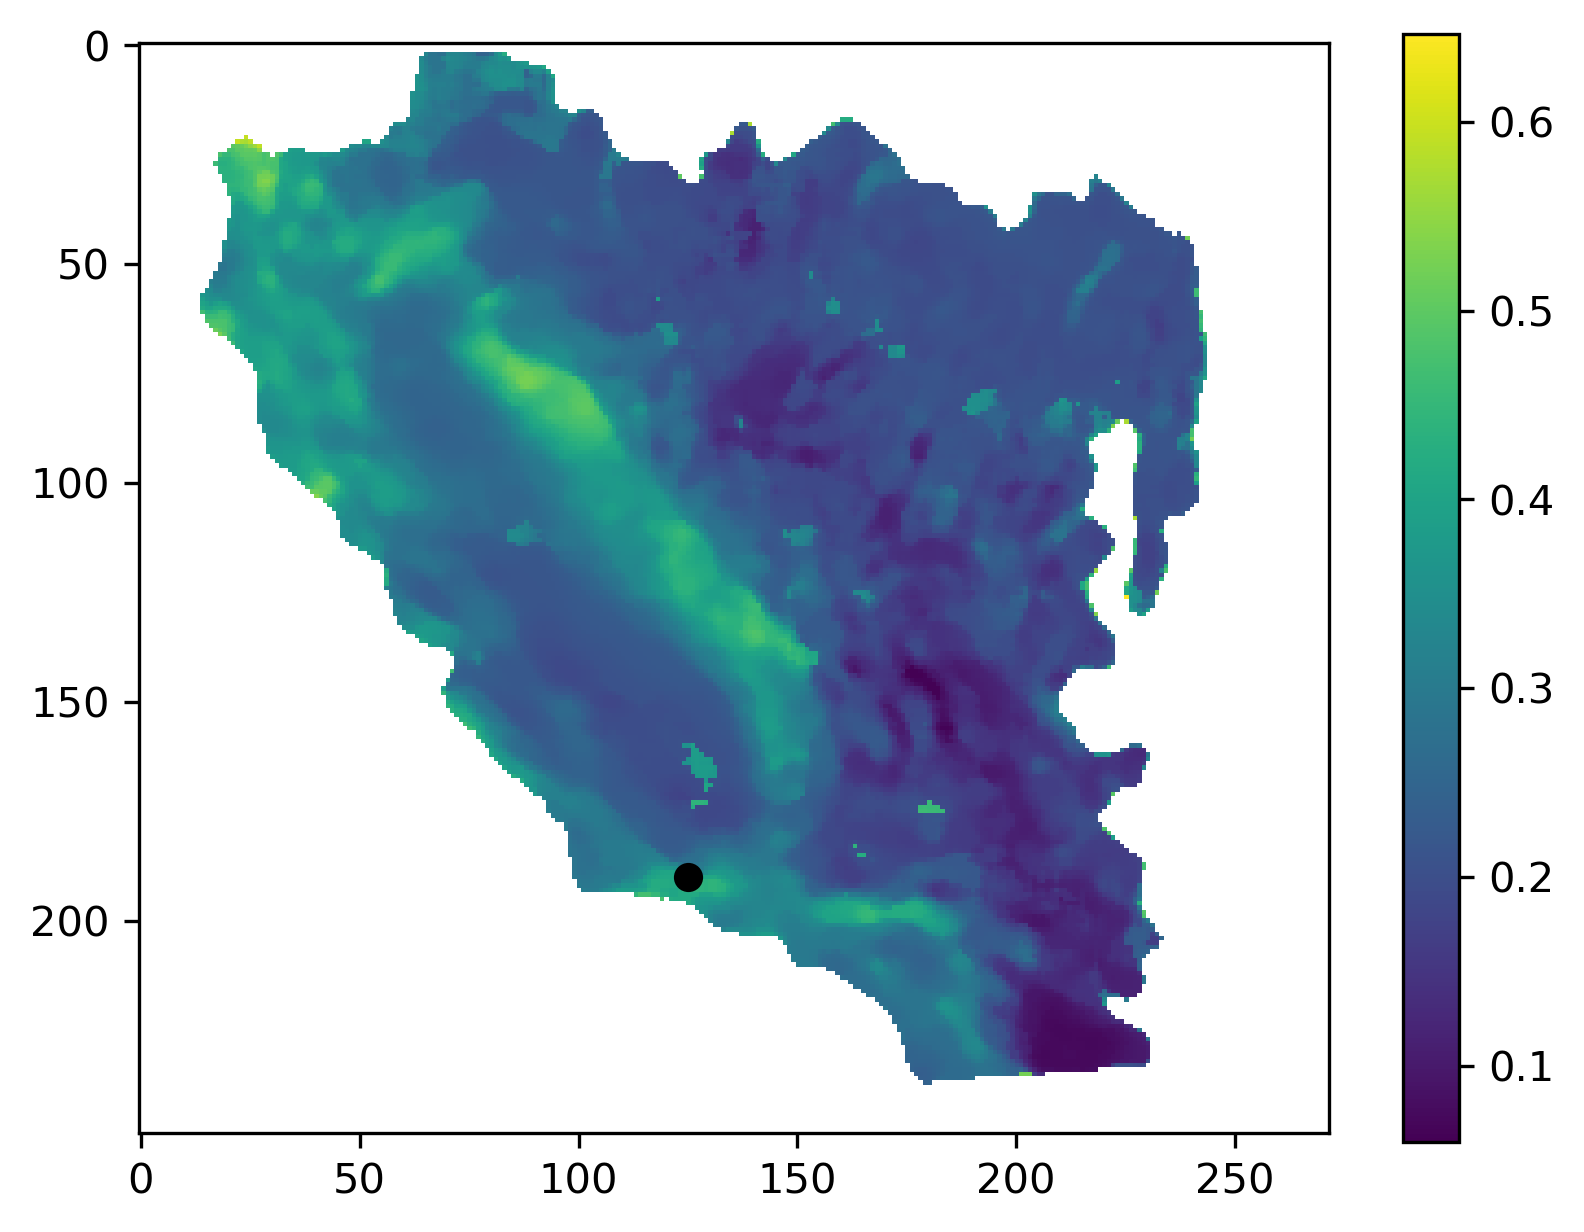

In [17]:
# Import AWI 15-yr recurrence grid

awi_15yr = xr.open_dataset('C:/Users/skcor/JPerkins_Astar/AWI_15yr_evd_smooth.nc')
awi_15yr = awi_15yr['tp'] # have to turn into data array from dataset by defining variable of interest

plt.imshow(awi_15yr)

row = 190
col = 125

# Pick a spot to plot the Astar time series
plt.plot(col,row,'ko')

plt.colorbar()

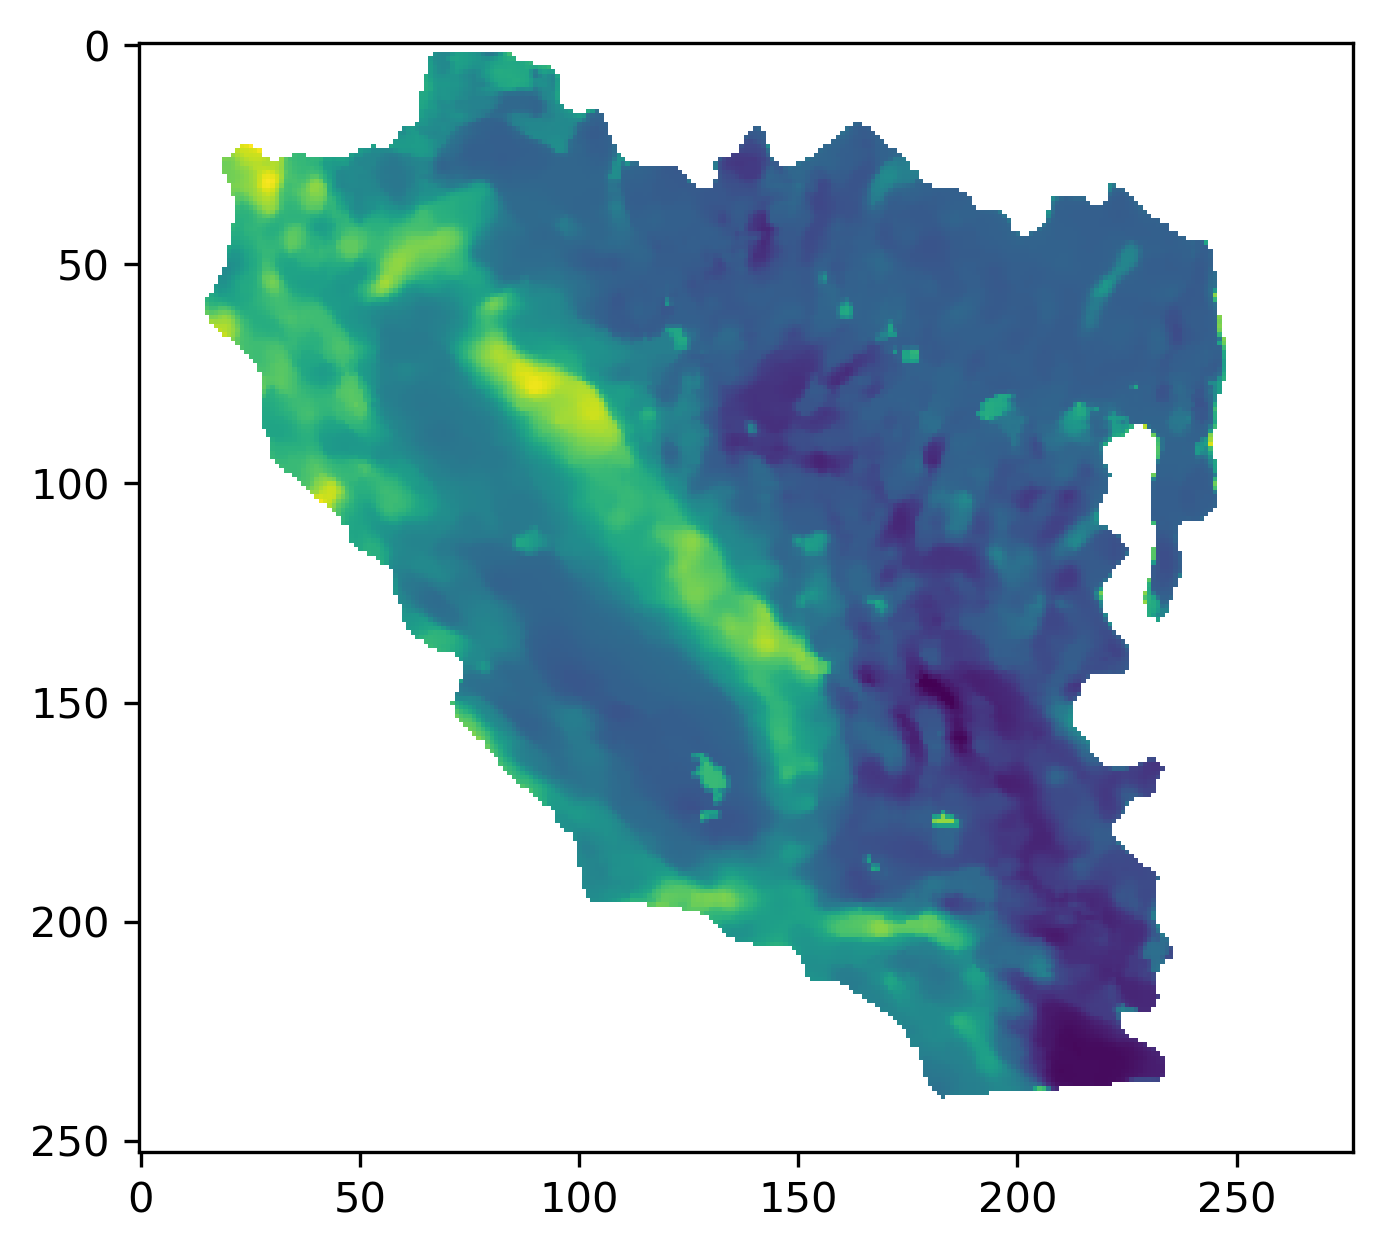

In [18]:
# Calculate Astar for WY23 by dividing WY AWI by the 15-yr Astar values

# Note: because of the projection shift in the NOAA precipitation data after Sep. 2020, the grid sizes are 
# different between the WY23 data and the 15-year Astar data. So, we need to interpolate the WY23 data to the 
# other grid. 

awi_15yr = awi_15yr.interp_like(a23[1,:,:])
# a23 = a23.interp_like(awi_15yr)
# a23 = a23+0.18

# we can then calculate A*
astar_WY23 = a23/awi_15yr
# astar_WY23 # show data 

plt.imshow(awi_15yr)


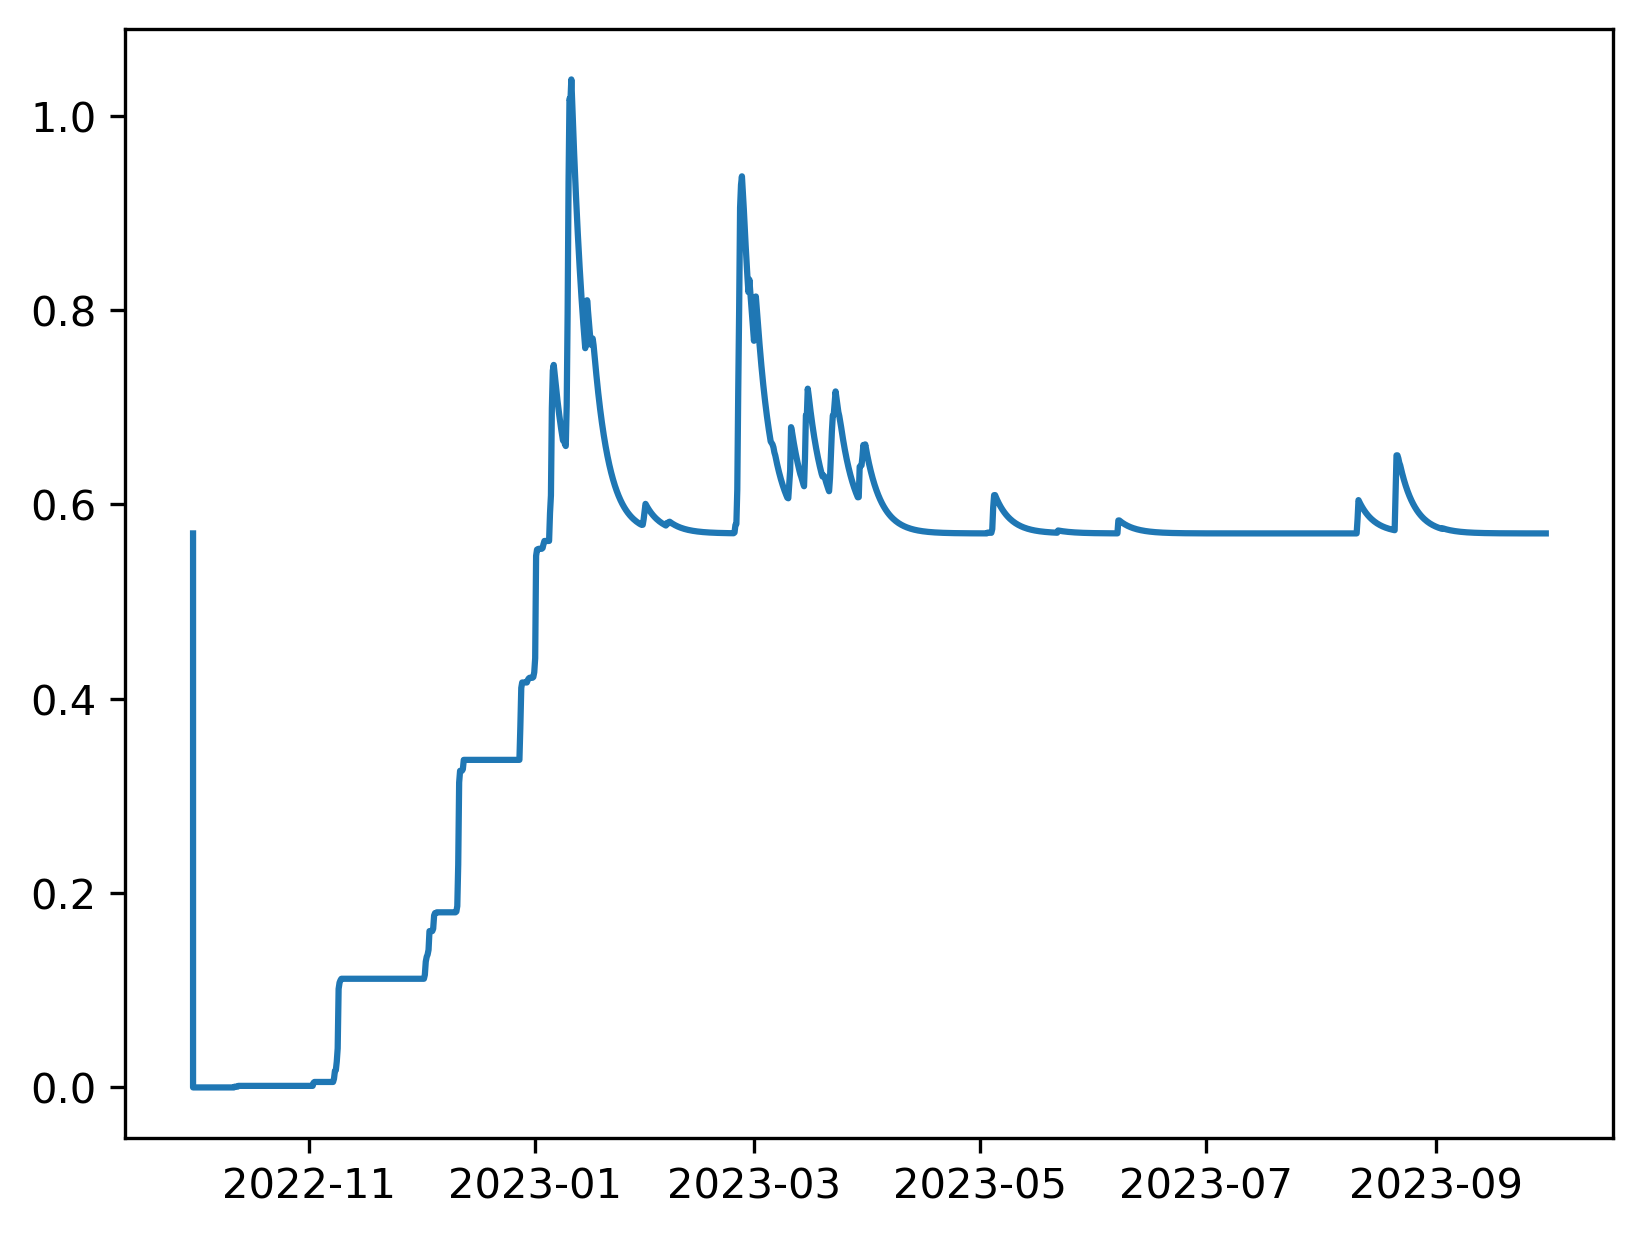

In [22]:
# Plot the time series for a random pixel in the Transverse range using the array above: 

plt.plot(astar_WY23['time'],astar_WY23[:,row,col])


In [23]:
# Let's define the time window for the Jan 10th storm that hammered southern CA

beginning = 397
end = 410

print('beginning: ',astar_WY23['time'][beginning])
print('end: ',astar_WY23['time'][end])

beginning:  <xarray.DataArray 'time' ()> Size: 8B
array('2023-01-08T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time         datetime64[ns] 8B 2023-01-08T18:00:00
    spatial_ref  int32 4B 0
end:  <xarray.DataArray 'time' ()> Size: 8B
array('2023-01-12T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time         datetime64[ns] 8B 2023-01-12
    spatial_ref  int32 4B 0


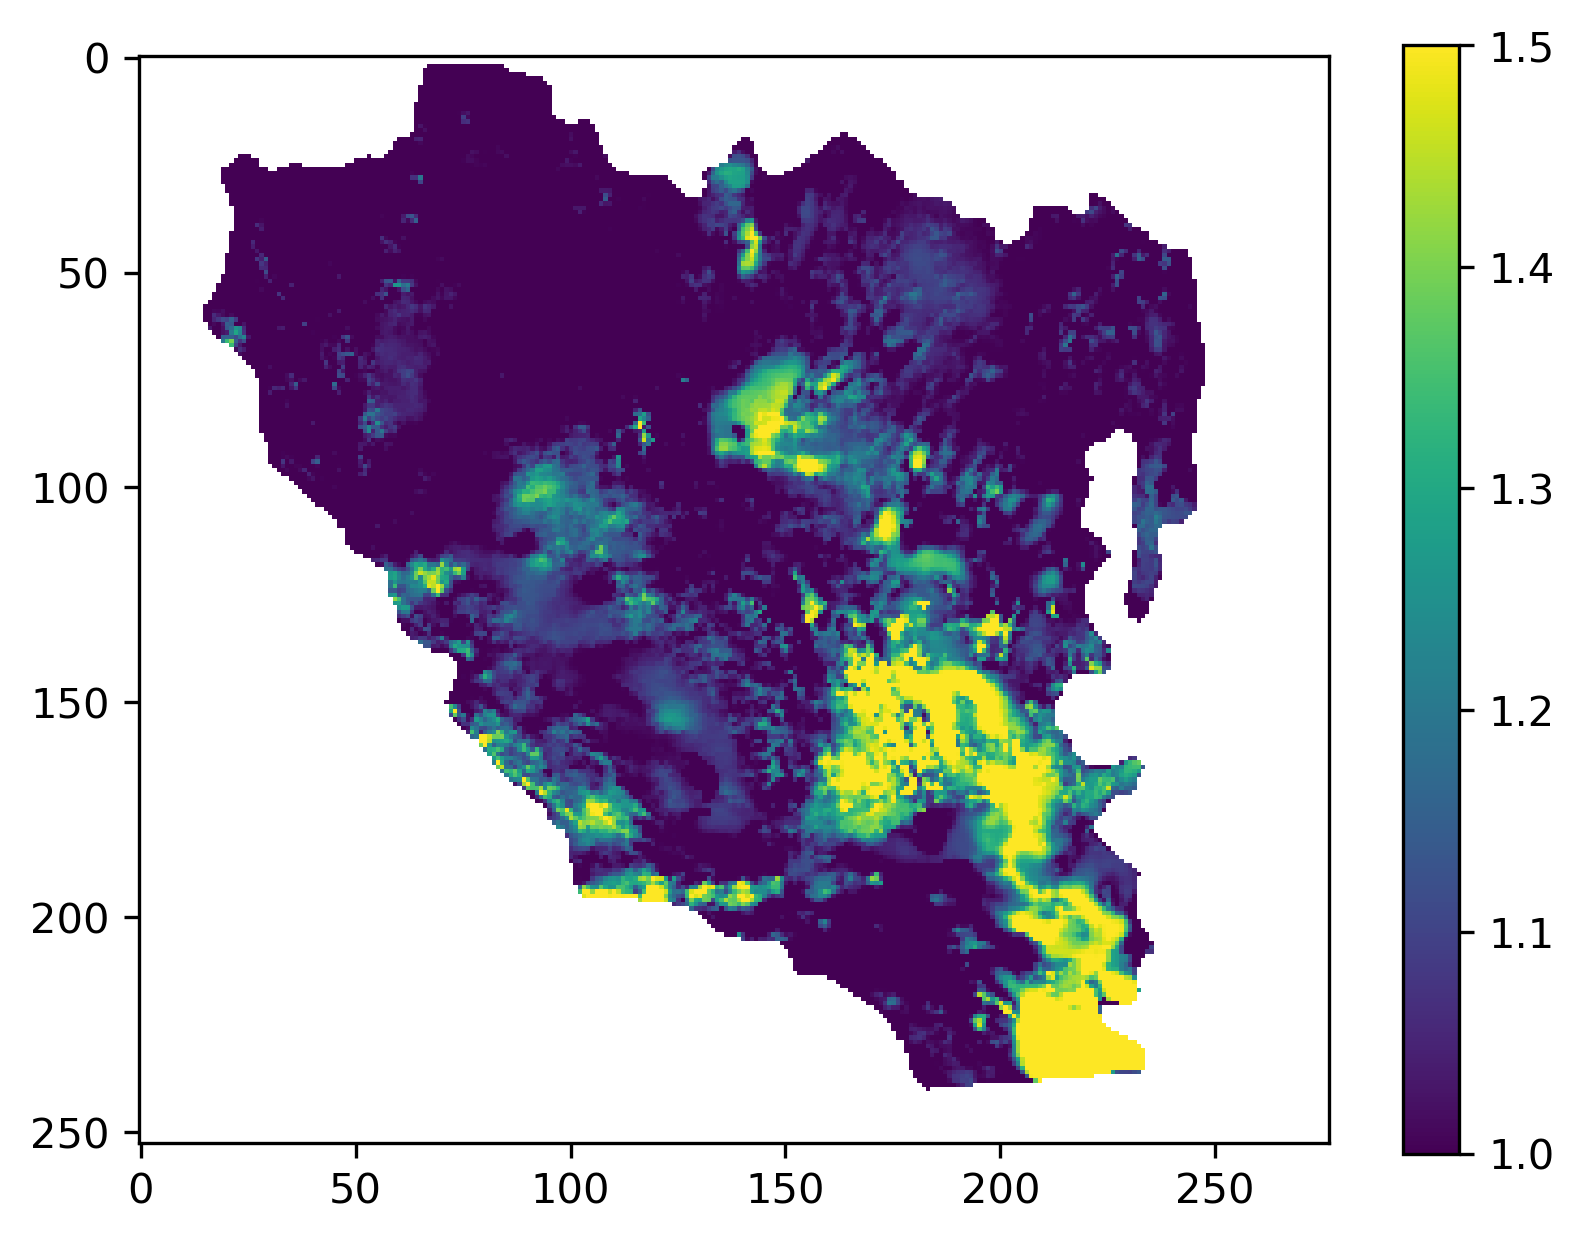

In [24]:
# segment the A* prism to the dates above

astar_jan10 = astar_WY23[beginning:end,:,:]

# calculate maximum value over storm window
astar_jan10_max = np.amax(astar_WY23,axis=0) # we want the maximum value over the time axis, which is the 0 axis in the dataarray

# do a basic plot just to see
plt.imshow(astar_jan10_max,vmin=1.0,vmax=1.5)
plt.colorbar()

# note, you can see that the values out in the desert blow up. this winds up being a slight issue with the 
# AWI model parameters out there, which will need to be dealth with in future work. So, those values are less trustworthy
# because the model never really "turns on" out there (the field capacithy parameter is too high), which messes with the 
# statistics for calculating the extreme values

In [26]:
# Download grids from pygmt server

azi = ["315/45"] # shading angles
nor = ["t1"] # shading normalization

grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-125, -115, 32, 42.5])
shade = pygmt.grdgradient(grid=grid, azimuth=azi, normalize=nor) # calculate shaded relief 

# you can find more information on pygmt.org. here's an example: 
# https://www.pygmt.org/latest/get_started/02_contour_map.html

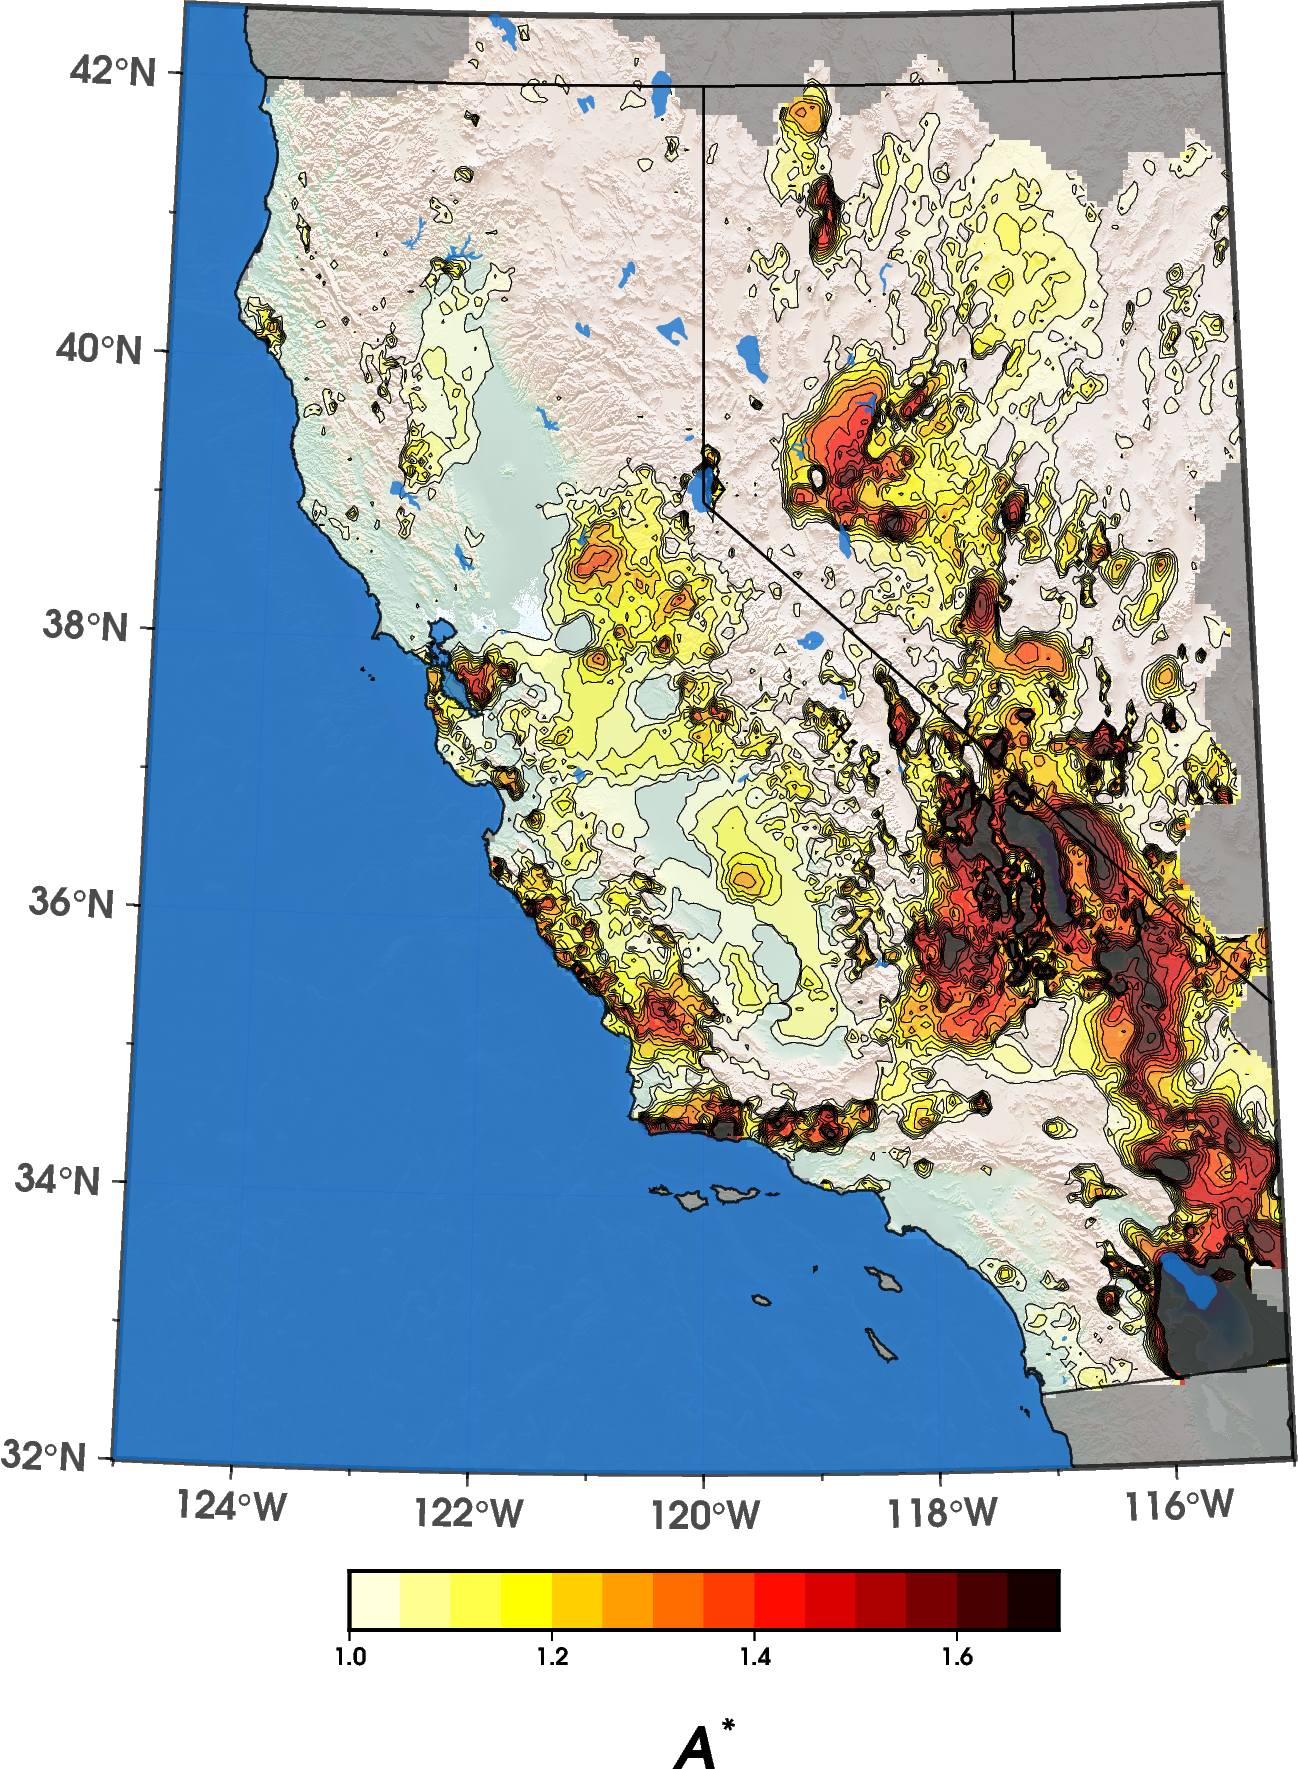

In [27]:
fig = pygmt.Figure()

# Define a colormap to be used for topography
terra = pygmt.makecpt(cmap="terra", series=[-100, 4000])

# Define figure configuration
pygmt.config(FONT_TITLE="10p,5", MAP_TITLE_OFFSET="1p", MAP_FRAME_TYPE="plain")
font = "10p,AvantGarde-Demi,black"
do = 0.8
t = 0
p = "1.5p,RED2"
pen = "1.5p,WHITE"
s = "r+s" 
pygmt.config(FONT="AvantGarde-Demi")

# ######################


pygmt.makecpt(cmap="terra", series=[-100, 4000])
fig.grdimage(grid=grid,shading=shade,
             projection="L-120/37/32/39/10c", 
             cmap=True,
#              frame=['+t"(a) Dec.30-Jan.3"'],
             transparency=60,
            )
# pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
# fig.grdimage(grid=shade,
#              projection="L-120/37/32/39/6c", 
#              cmap=True,
#              frame=['+t"(a) Dec.31-Jan.4"'],
#              transparency=20,
#             )
minc = 1.0
maxc = 1.7
dc = 0.05
pygmt.makecpt(cmap="matlab/hot", reverse=True, series=[minc, maxc, dc])

# Astarm = Astar23_s1max.where(Astar23_s1max>=minc,0)


fig.grdimage(grid=astar_jan10_max,
             projection="L-120/37/32/39/10c", 
             cmap=True,
             frame=True,
             nan_transparent="+z0", # makes zero values transparent
             transparency=30,
            )
fig.grdcontour(
#     annotation=1,
    interval=dc,
    grid=astar_jan10_max,
#     grid=Astarm,
    limit=[minc, maxc],
    pen="0.1p,black"
)
fig.coast(shorelines=["1/0.5p,black"],borders=["1/0.5p,black", "2/0.5p,black"],water="dodgerblue3",transparency=20)

# fig.plot(x=s1_pts_sorted.LONG, y=s1_pts_sorted.LAT, style="c0.095c", fill="gold", pen="saddlebrown", transparency=10)
# fig.plot(x=s1_usgs.POINT_X, y=s1_usgs.POINT_Y, style="t0.09c", fill="gold", pen="saddlebrown", transparency=10)

fig.colorbar(frame=["a"], position="JBC+/1.0c+w6c/0.5c")
fig.text(text="A@+*",position="CB",offset="0c/-2.5c",font="14p,AvantGarde-DemiOblique,black", no_clip=True)

fig.show()

fig.savefig('Astar_Results.png',dpi=300)

#
_____________________________________________________________
# LP-DAAC's OPERA DIST-ALERT-HLS Methodology

The OPERA Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 (HLS) product Version 1 utilizes data from Landsat 8, Landsat 9, Sentinel-2A, and Sentinel-2B to map vegetation disturbance alerts at 30-meter spatial resolution. These alerts signify decreased vegetation cover within HLS pixels, offering insight into disturbance trends and auxiliary disturbance information. The data, provided in Cloud Optimized GeoTIFF format, consists of 19 layers, including disturbance status, loss or anomaly, maximum loss anomaly, disturbance confidence, date of disturbance, count of observations with loss anomalies, days of ongoing anomalies, and day of last disturbance detection, among others. This comprehensive dataset enhances sensitivity to land changes, providing valuable information on both large magnitude/short duration and small magnitude/long duration disturbances.

### Data Used in the Example

* **30 meter (m) global OPERA Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 provisional product (Version 0) - [OPERA_L3_DIST-ALERT-HLS_V1](https://lpdaac.usgs.gov/products/opera_l3_dist-alert-hls_v1v001/)**<br>
    - The Observational Products for End-Users from Remote Sensing Analysis (OPERA) Land Surface Disturbance Alert from Harmonized Landsat Sentinel-2 (HLS) provisional data product Version 0 maps vegetation disturbance alerts from data collected by Landsat 8 and Landsat 9 Operational Land Imager (OLI) and Sentinel-2A and Sentinel-2B Multi-Spectral Instrument (MSI). Vegetation disturbance alert is detected at 30 meter (m) spatial resolution when there is an indicated decrease in vegetation cover within an HLS pixel. The product also provides auxiliary generic disturbance information as determined from the variations of the reflectance through the HLS scenes to provide information about more general disturbance trends. HLS data represent the highest temporal frequency data available at medium spatial resolution. The combined observations will provide greater sensitivity to land changes, whether of large magnitude/short duration, or small magnitude/long duration.
    - The OPERA_L3_DIST-ALERT-HLS (or DIST-ALERT) data product is provided in Cloud Optimized GeoTIFF (COG) format, and each layer is distributed as a separate file. There are 19 layers contained within in the DIST-ALERT product: vegetation disturbance status, current vegetation cover indicator, current vegetation anomaly value, historical vegetation cover indicator, max vegetation anomaly value, vegetation disturbance confidence layer, date of initial vegetation disturbance, number of detected vegetation loss anomalies, and vegetation disturbance duration. See the Product Specification for a more detailed description of the individual layers provided in the DIST-ALERT product.
* **Science Dataset (SDS) Layers**
    - VEG_ANOM_MAX (Maximum Vegetation Anomaly Layer)
    - VEG_DIST_DATE (Vegetation Disturbance Date Layer)
    - VEG_DIST_STATUS (Vegetation Disturbance Status Layer)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
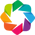

In [28]:
# Notebook dependencies
import earthaccess
import os
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
from pystac_client import Client  
from datetime import datetime
from shapely.geometry import box
from shapely.geometry import shape
import pandas as pd
import geopandas as gpd
from osgeo import gdal
from rioxarray.merge import merge_arrays

import folium
from folium import plugins

import geoviews as gv

import holoviews as hv
hv.extension('bokeh')
gv.extension('bokeh', 'matplotlib')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')
from src.dist_utils import (intersection_percent, stack_bands, time_and_area_cube,
                            compute_area, standard_date, colorize, mask_rasters, getbasemaps, transform_data_for_folium)

In [29]:
inDir = os.getcwd()
os.chdir(inDir)

earthaccess.login(persist=True)

In [31]:
# GDAL configurations used to successfully access PODAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')

In [32]:
# User-Defined Parameters
aoi = box(-119.977844,34.460516,-119.120911,35.051558)
start_date = datetime(2022, 1, 1)                                   
# stop_date = f"{datetime.today().strftime('%Y-%m-%d')} 23:59:59"
stop_date = datetime(2023,4,18)
overlap_threshold = 20                                                  
cloud_cover_threshold = 20                                           

print(f"Search between {start_date} and {stop_date}")
print(f"With AOI: {aoi.__geo_interface__}")

Search between 2022-01-01 00:00:00 and 2023-04-18 00:00:00
With AOI: {'type': 'Polygon', 'coordinates': (((-119.120911, 34.460516), (-119.120911, 35.051558), (-119.977844, 35.051558), (-119.977844, 34.460516), (-119.120911, 34.460516)),)}


In [33]:
# Search data through CMR-STAC API
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_V1']

search_params = {"collections": collections,
                 "intersects": aoi.__geo_interface__,
                 "datetime": [start_date, stop_date],
                 "limit": 50,
                 "max_items": 1000
                }
search_dist = api.search(**search_params)

In [34]:
# Filter datasets based on spatial overlap and cloud cover
intersects_geometry = aoi.__geo_interface__

#Check percent overlap values
print("Percent overlap before filtering: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in search_dist.items()])

# Check percent cloud cover values
print("\nPercent cloud cover before filtering: ")
print([f"{i.properties['eo:cloud_cover']}" for i in search_dist.items()])

Percent overlap before filtering: 
['23.98', '7.51', '7.51', '100.00', '42.24', '7.51', '27.34', '7.51', '28.09', '7.51', '100.00', '42.24', '7.51', '100.00', '42.24', '23.43', '7.41', '7.51', '27.38', '7.51', '100.00', '42.24', '7.51', '28.73', '7.51', '100.00', '42.24', '7.51', '24.64']

Percent cloud cover before filtering: 
['81', '95', '98', '75', '72', '70', '82', '58', '41', '10', '2', '0', '1', '0', '0', '30', '15', '36', '35', '61', '27', '47', '55', '51', '23', '15', '6', '2', '5']


In [35]:
# Apply spatial overlap and cloud cover threshold
dist_filtered = (
    i for i in search_dist.items() if (intersection_percent(i, intersects_geometry) 
                                       > overlap_threshold and 
                                       i.properties['eo:cloud_cover'] < cloud_cover_threshold)
)
dist_filtered

<generator object <genexpr> at 0x00000182F432E810>

In [36]:
dist_data = list(dist_filtered)
dist_data[0].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1',
 'properties': {'eo:cloud_cover': 2,
  'datetime': '2023-04-06T18:34:03.515000Z',
  'start_datetime': '2023-04-06T18:34:03.515Z',
  'end_datetime': '2023-04-06T18:34:27.398Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-120.2561777, 34.209667],
    [-119.0653735, 34.2355216],
    [-119.0901472, 35.2250277],
    [-120.2951835, 35.1982077],
    [-120.2561777, 34.209667]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_V1.v1/items/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_V1.v1'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/collections/OPERA_L3_DIST-ALERT-HLS_V1.v1'},
  {'rel': 'root

In [37]:
# Print search information
# Total granules
print(f"Total granules after search filter: {len(dist_data)}")

# Check percent overlap values
print("Percent-overlap: ")
print([f"{intersection_percent(i, intersects_geometry):.2f}" for i in dist_data])

# Check cloud cover values
print("Cloud-cover: ")
print([f"{x.properties['eo:cloud_cover']}" for x in dist_data])

Total granules after search filter: 7
Percent-overlap: 
['100.00', '42.24', '100.00', '42.24', '100.00', '42.24', '24.64']
Cloud-cover: 
['2', '0', '0', '0', '15', '6', '5']


In [39]:
# Visualize the DIST tile boundary and the user-defined box
geom_df = []
for d,_ in enumerate(dist_data):
    geom_df.append(shape(dist_data[d].geometry))

geom_granules = gpd.GeoDataFrame({'geometry':geom_df})
granules_poly = gv.Polygons(geom_granules).opts(line_color='blue', color=None)

# Use geoviews to combine a basemap with the shapely polygon of our Region of Interest (ROI)
base = gv.tile_sources.EsriImagery.opts(width=1000, height=1000)

# Get the user-specified aoi
geom_aoi = shape(intersects_geometry)
aoi_poly = gv.Polygons(geom_aoi).opts(line_color='yellow', color=None)

# Plot using geoviews wrapper
granules_poly*base*aoi_poly

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

In [40]:
# Create table of search results
dist_data_df = []
for item in dist_data:
    item.to_dict()
    fn = item.id.split('_')
    ID = fn[3]
    sensor = fn[6]
    dat = item.datetime.strftime('%Y-%m-%d')
    spatial_coverage = intersection_percent(item, intersects_geometry)
    cloud_cover = item.properties['eo:cloud_cover']
    geom = item.geometry
    bbox = item.bbox

    # Take all the band href information 
    band_links = [item.assets[links].href for links in item.assets.keys()]
    dist_data_df.append([ID,sensor,dat,geom,bbox,spatial_coverage,cloud_cover,band_links])

dist_data_df = pd.DataFrame(dist_data_df, columns = ['TileID', 'Sensor', 'Date', 'Coords', 'bbox','SpatialCoverage','CloudCover','BandLinks'])
dist_data_df

TileID Sensor        Date  \
0  T11SKU     L9  2023-04-06   
1  T10SGD     L9  2023-04-06   
2  T11SKU    S2A  2023-04-06   
3  T10SGD    S2A  2023-04-06   
4  T11SKU     L8  2023-04-14   
5  T10SGD     L8  2023-04-14   
6  T11SKU     L9  2023-04-15   

                                              Coords  \
0  {'type': 'Polygon', 'coordinates': [[[-120.256...   
1  {'type': 'Polygon', 'coordinates': [[[-119.638...   
2  {'type': 'Polygon', 'coordinates': [[[-120.256...   
3  {'type': 'Polygon', 'coordinates': [[[-119.638...   
4  {'type': 'Polygon', 'coordinates': [[[-120.256...   
5  {'type': 'Polygon', 'coordinates': [[[-119.638...   
6  {'type': 'Polygon', 'coordinates': [[[-119.474...   

                                               bbox  SpatialCoverage  \
0  [-120.295183, 34.209667, -119.065374, 35.225028]       100.000000   
1  [-120.828937, 34.206816, -119.598005, 35.221968]        42.237508   
2  [-120.295183, 34.209667, -119.065374, 35.225028]       100.000000   
3  [-120.828937, 34.206816, -119.598005, 35.223133]        42.237508   
4  [-120.295183, 34.209667, -119.065374, 35.225028]       100.000000   
5  [-120.828937, 34.206816, -119.598005, 35.222036]        42.237508   
6  [-119.474188, 34.227951, -119.065374, 35.225028]        24.642767   

   CloudCover                                          BandLinks  
0           2  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
1           0  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
2           0  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
3           0  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
4          15  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
5           6  [https://data.lpdaac.earthdatacloud.nasa.gov/l...  
6           5  [https://data.lpdaac.earthdatacloud.nasa.gov/l...

## 3. Load and Visualize DIST-ALERT-HLS COGs from the Cloud

If one tile is extracted from the table above, its individual layer bandlinks can be viewed below. This means the user can access each layer of the tile individually and use it to produce a visualization over a basemap. An example of this process is detailed in this section.

In [41]:
viz_dist = dist_data_df.iloc[0]
viz_dist.BandLinks

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1_VEG-DIST-STATUS.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1_VEG-IND.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1_VEG-ANOM.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9_30_v1/OPERA_L3_DIST-ALERT-HLS_T11SKU_20230406T183403Z_20231220T215517Z_L9


Two tiles collected on the same date from roughly the same geographic area are extracted from the filtered collection: one obtained from Landsat-9 and the other from Sentinel-2. Using the listed bandlinks shown above, the three layers of interest (VEG_ANOM_MAX, VEG_DIST_DATE, and VEG_DIST_STATUS) are extracted from both tiles and are merged respectively.



In [42]:
T42RUR_VEG_ANOM_MAX, T42RUR_VEG_ANOM_MAX_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[4])
T42RVR_VEG_ANOM_MAX, T42RVR_VEG_ANOM_MAX_cm = transform_data_for_folium(dist_data_df.iloc[2].BandLinks[4])
merged_VEG_ANOM_MAX = merge_arrays([T42RUR_VEG_ANOM_MAX, T42RVR_VEG_ANOM_MAX])


T42RUR_VEG_DIST_DATE, T42RUR_VEG_DIST_DATE_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[6])
T42RVR_VEG_DIST_DATE, T42RVR_VEG_DIST_DATE_cm = transform_data_for_folium(dist_data_df.iloc[2].BandLinks[6])
merged_VEG_DIST_DATE = merge_arrays([T42RUR_VEG_DIST_DATE, T42RVR_VEG_DIST_DATE])

T42RUR_VEG_DIST_STATUS, T42RUR_VEG_DIST_STATUS_cm = transform_data_for_folium(dist_data_df.iloc[1].BandLinks[0])
T42RVR_VEG_DIST_STATUS, T42RVR_VEG_DIST_STATUS_cm = transform_data_for_folium(dist_data_df.iloc[2].BandLinks[0])
merged_VEG_DIST_STATUS = merge_arrays([T42RUR_VEG_DIST_STATUS, T42RVR_VEG_DIST_STATUS])


The respective merged layers are then masked such that "No Data" pixels become transparent, leaving only significant pixels behind. They are then colorized with the *hot_r* colormap, making them easier to interpret by the user.

In [43]:
masked_VEG_ANOM_MAX, masked_VEG_DIST_DATE,masked_VEG_DIST_STATUS = mask_rasters(merged_VEG_ANOM_MAX, 
                                                                                merged_VEG_DIST_DATE, 
                                                                                merged_VEG_DIST_STATUS)

colorized_VEG_ANOM_MAX = colorize(masked_VEG_ANOM_MAX[0])
colorized_VEG_DIST_DATE = colorize(masked_VEG_DIST_DATE[0])
colorized_VEG_DIST_STATUS = colorize(masked_VEG_DIST_STATUS[0])


In the map below, the filtered and colored layers are overlapped upon a basemap. There is a small layer symbol in the upper right corner of the map, and if the user hovers over the icon, they can click the checkboxes to manipulate the basemap or view the layers separately rather than all together if they choose to do so. The user can also hover their cursor over the map to get longitudinal coordinates, as well as zoom in/out to specific pixels and click/drag to navigate around the map.


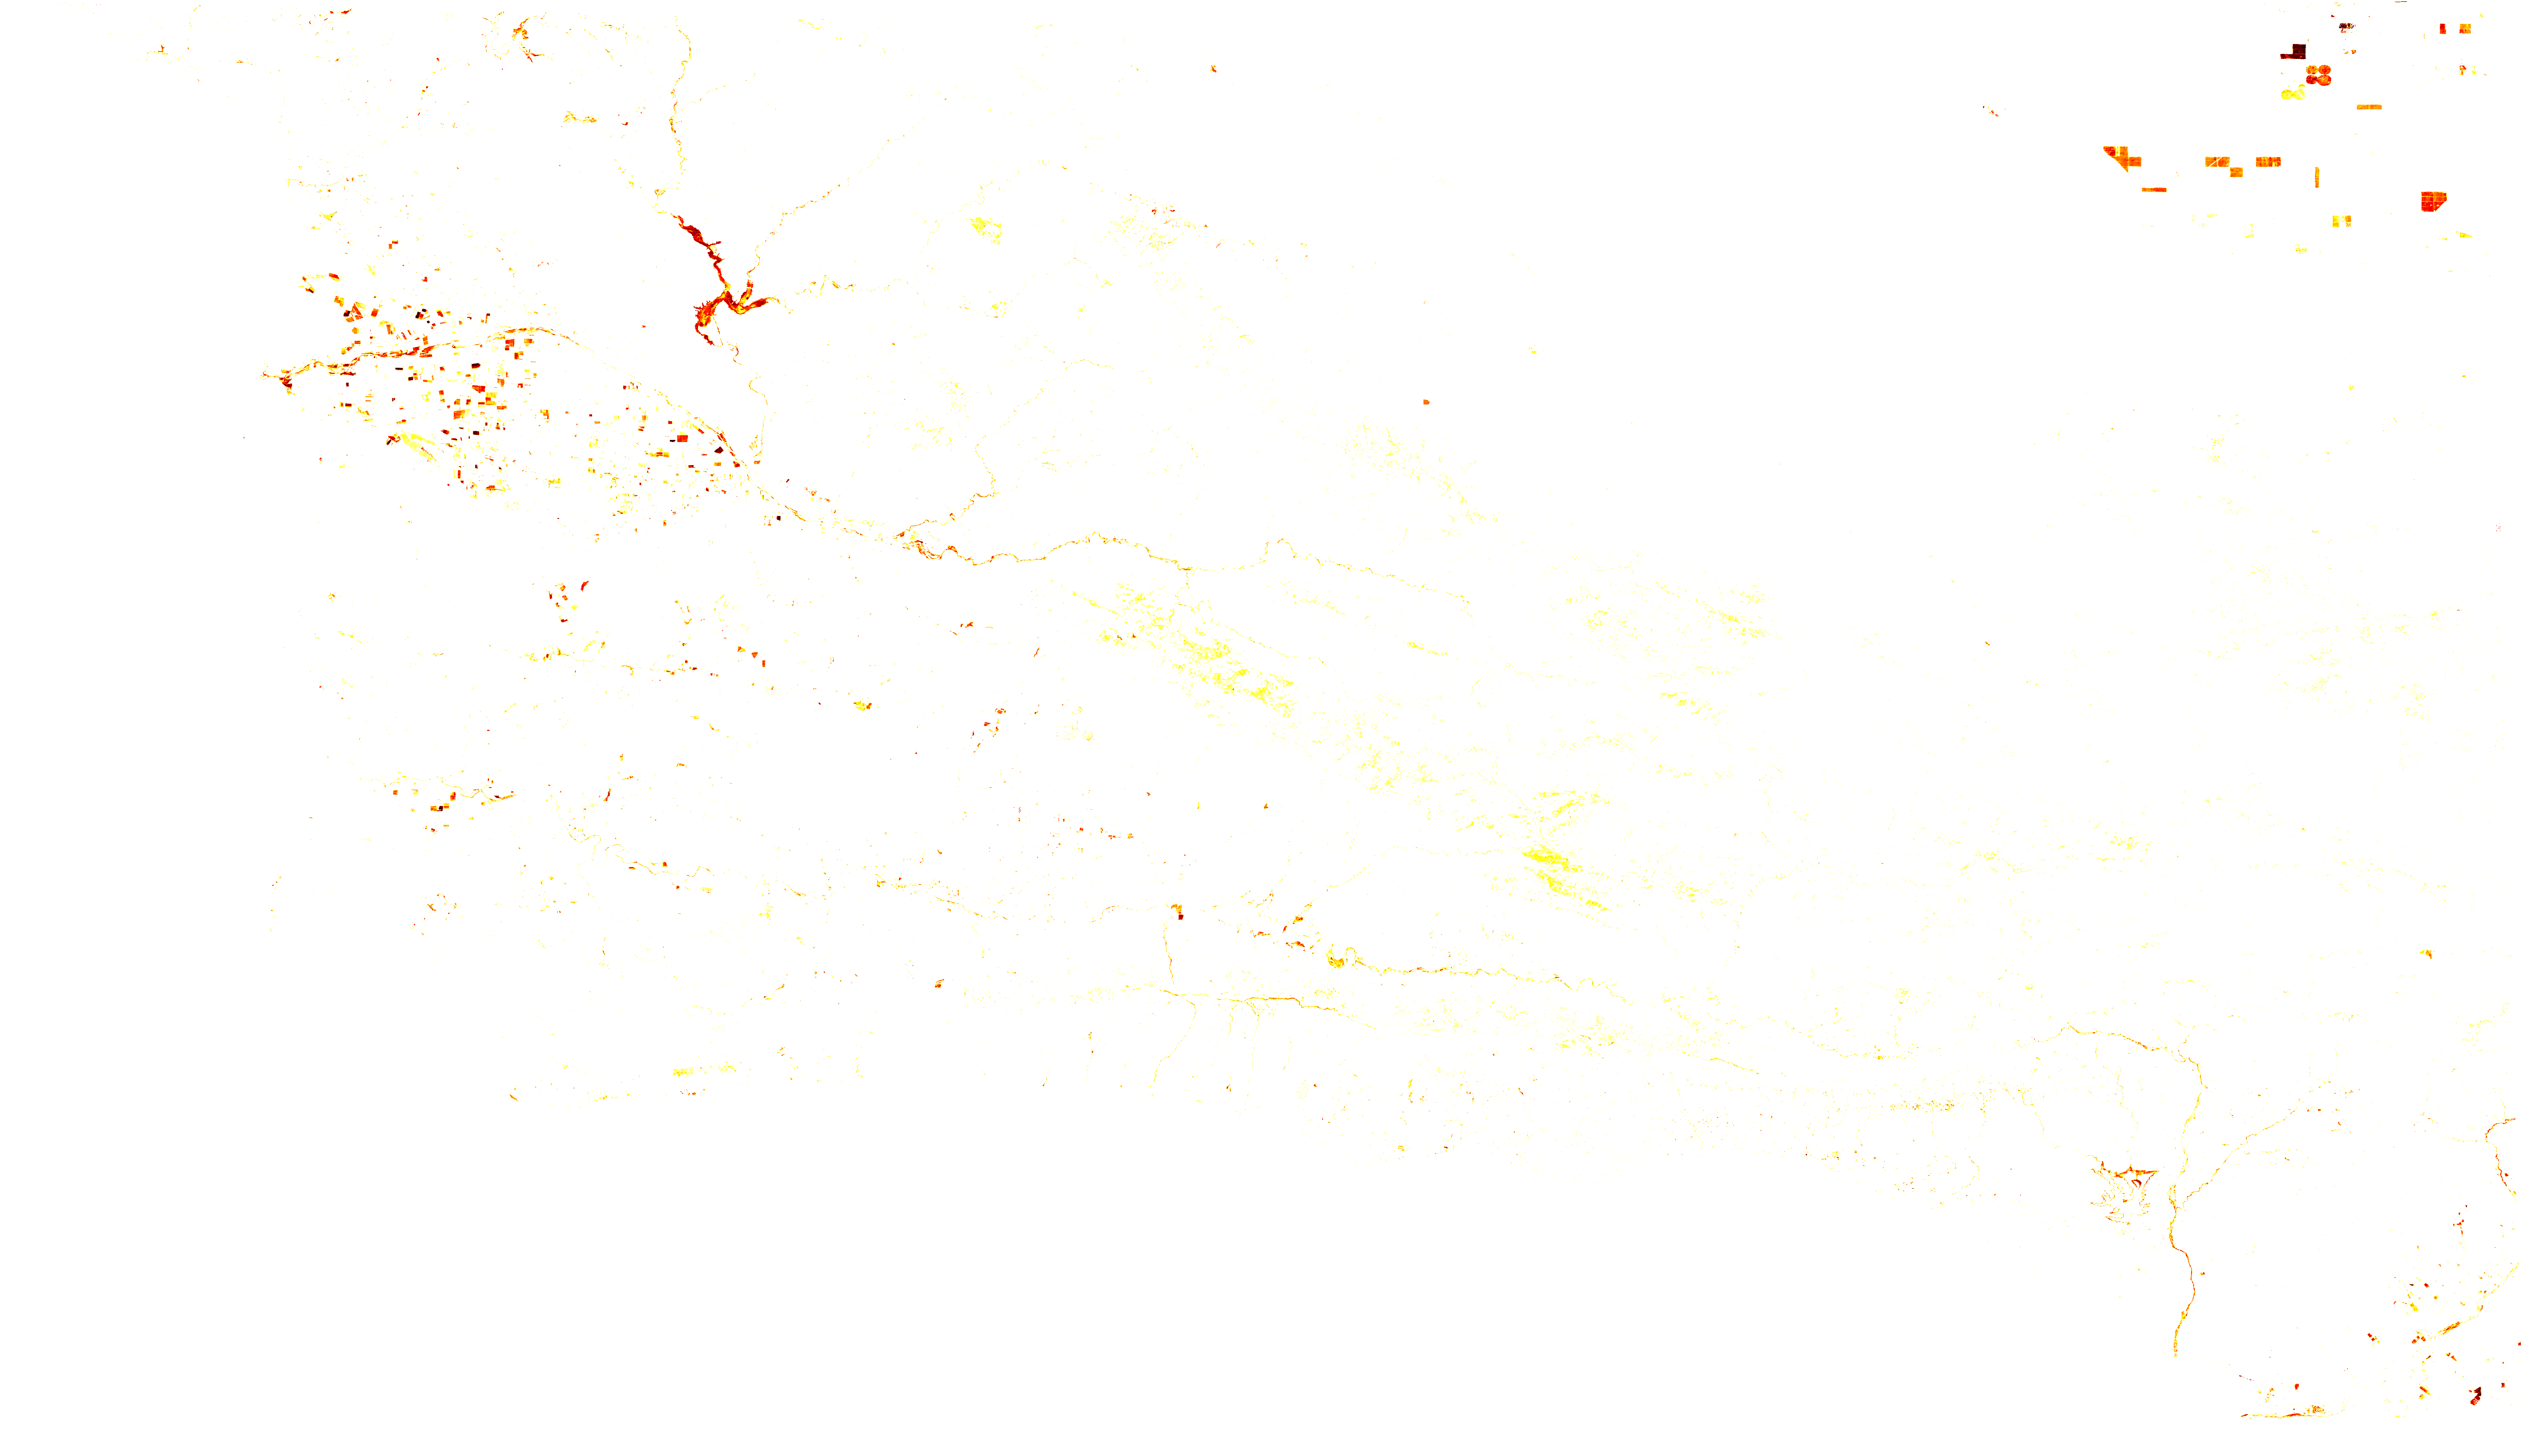
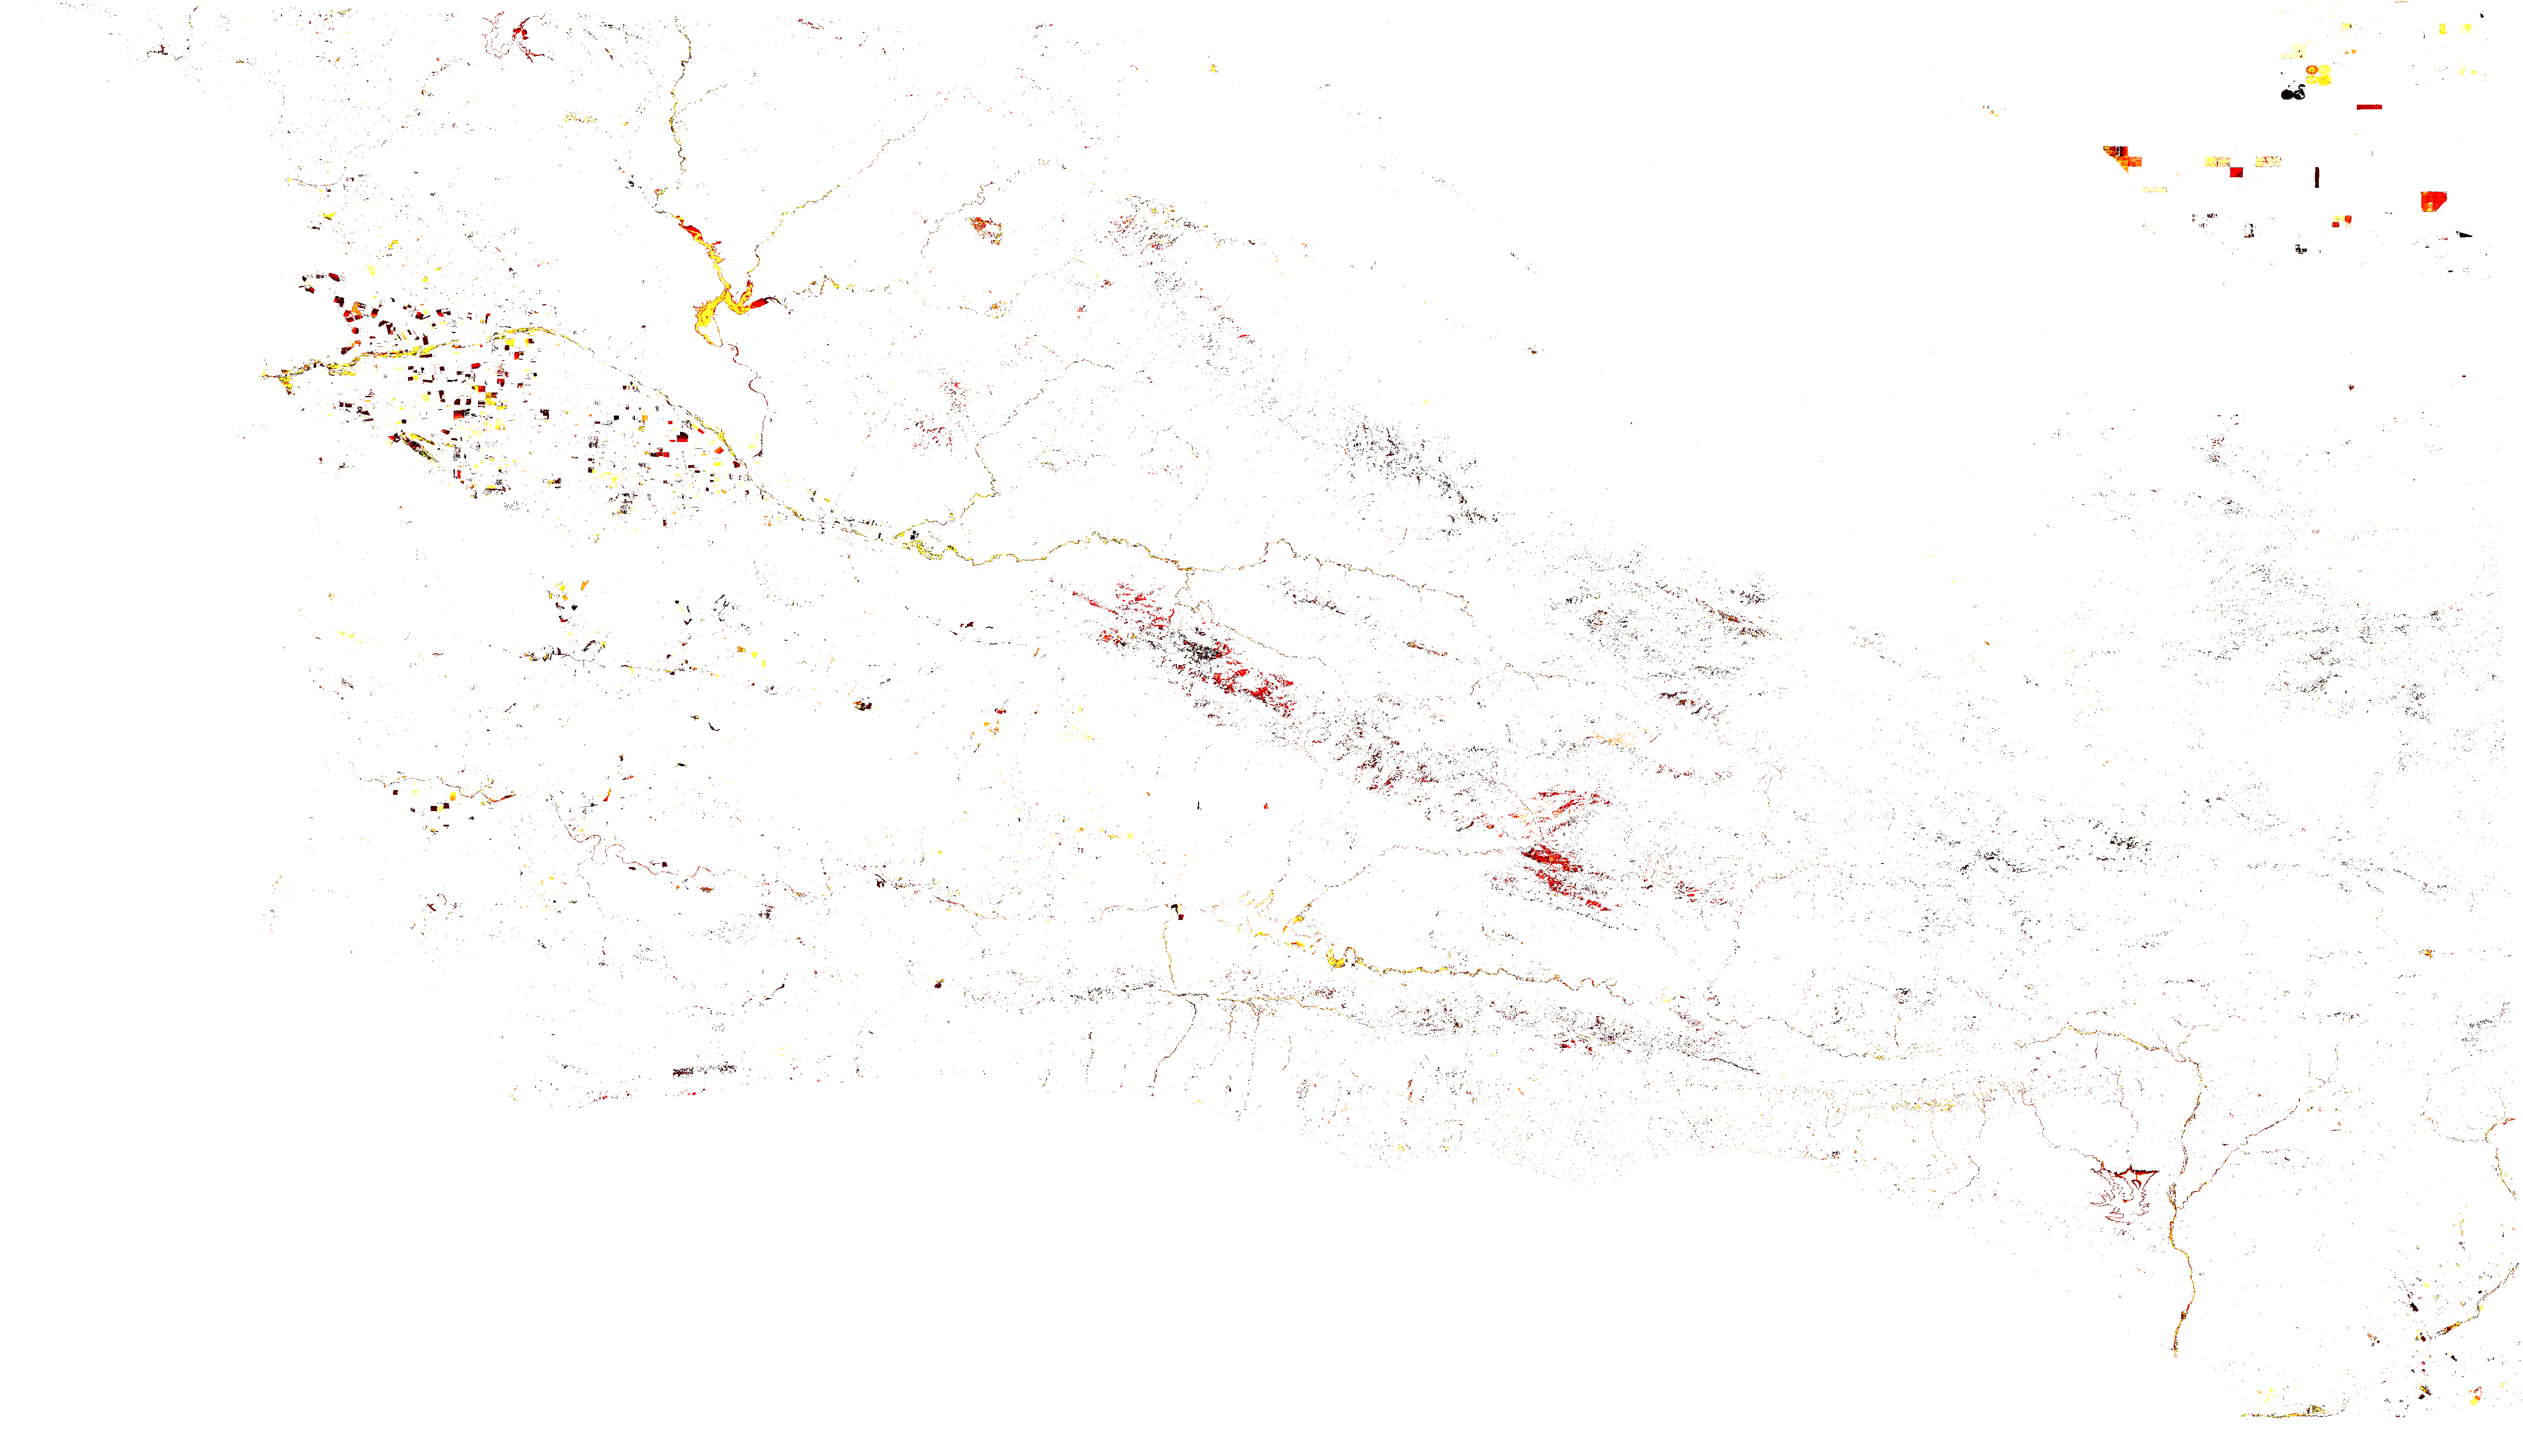
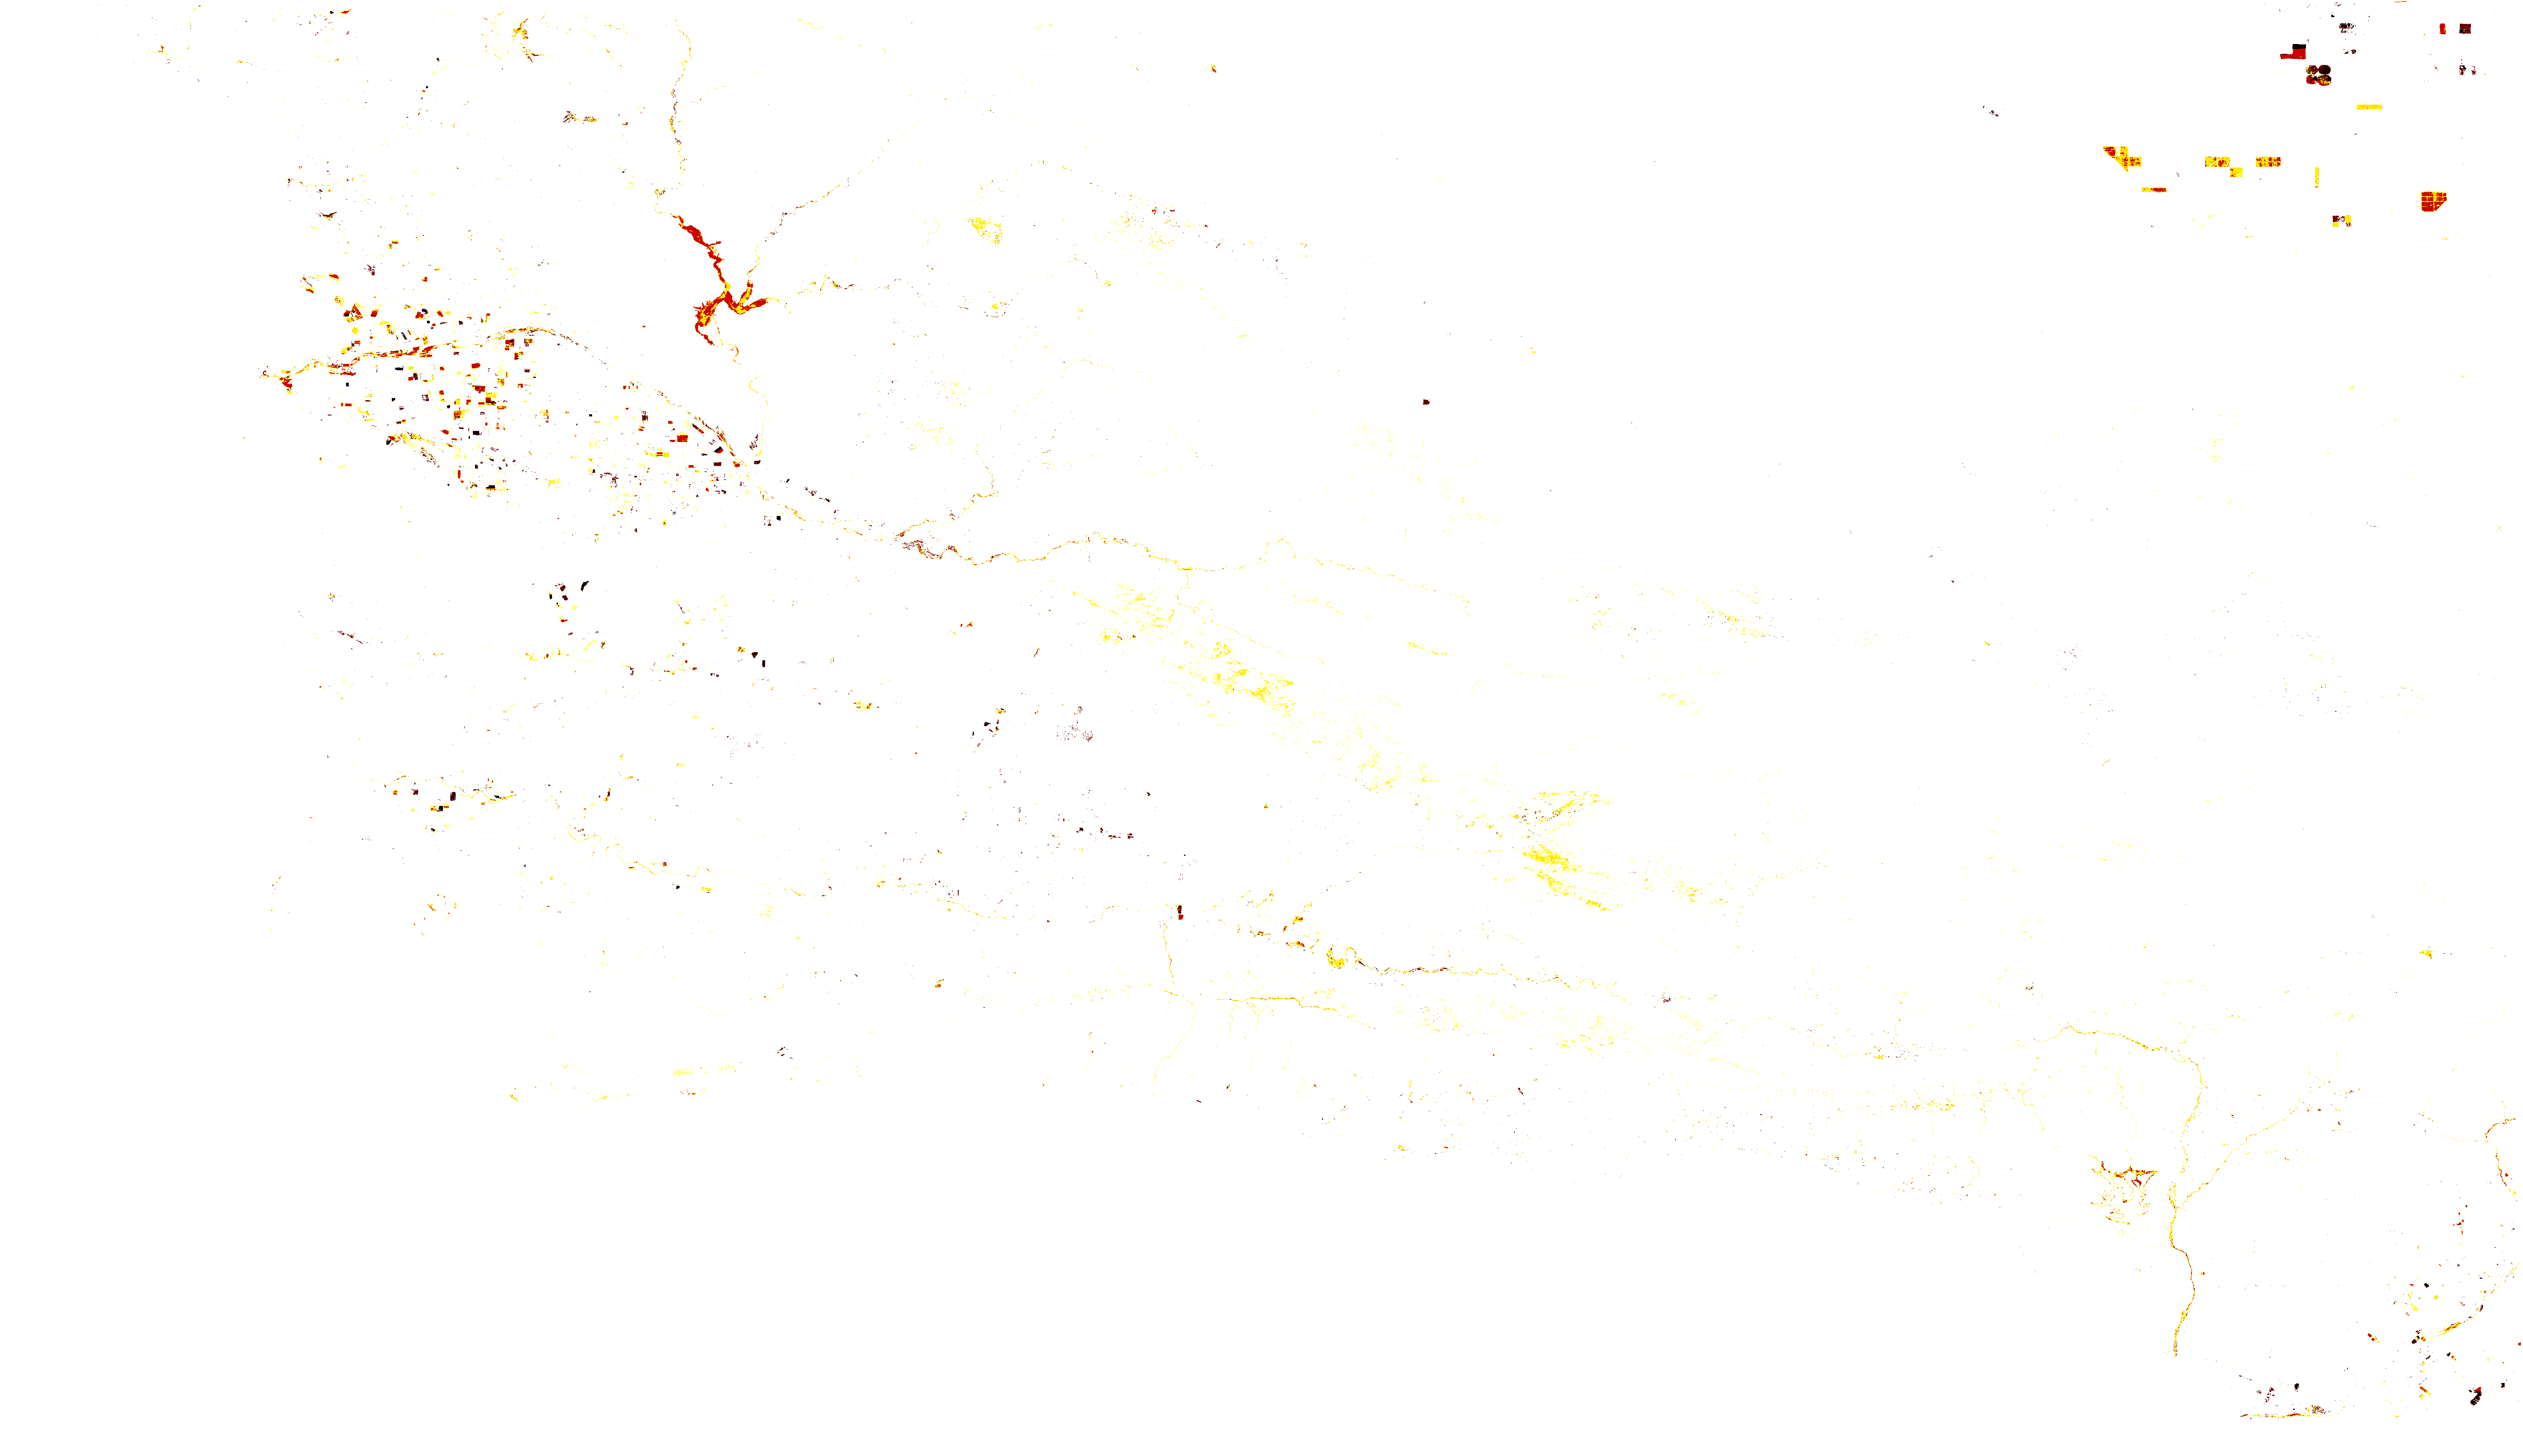

In [44]:
# Initialize Folium basemap
xmid =(merged_VEG_ANOM_MAX.x.values.min()+merged_VEG_ANOM_MAX.x.values.max())/2 ;
ymid = (merged_VEG_ANOM_MAX.y.values.min()+merged_VEG_ANOM_MAX.y.values.max())/2

m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='CartoDB positron', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_ANOM_MAX, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_ANOM_MAX.y.values.min(),merged_VEG_ANOM_MAX.x.values.min()],
                                                [merged_VEG_ANOM_MAX.y.values.max(),merged_VEG_ANOM_MAX.x.values.max()]],
                                        name='VEG_ANOM_MAX',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_DIST_DATE, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_DIST_DATE.y.values.min(),merged_VEG_DIST_DATE.x.values.min()],
                                                [merged_VEG_DIST_DATE.y.values.max(),merged_VEG_DIST_DATE.x.values.max()]],
                                        name='VEG_DIST_DATE',
                                        show=True).add_to(m)

folium.raster_layers.ImageOverlay(colorized_VEG_DIST_STATUS, 
                                        opacity=0.6, 
                                        bounds=[[merged_VEG_DIST_STATUS.y.values.min(),merged_VEG_DIST_STATUS.x.values.min()],
                                                [merged_VEG_DIST_STATUS.y.values.max(),merged_VEG_DIST_STATUS.x.values.max()]],
                                        name='VEG_DIST_STATUS',
                                        show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=200, height=200)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m

The current working code serves as a demonstration of how each model functions individually. My plan is to further develop and automate these models to enhance their functionality. The ultimate goal is for the system to provide detailed information on landslide events, including the specific dates when these events occur. Additionally, the automated system will generate polygons that identify the precise locations where landslides have taken place following storm systems. This advancement will enable more accurate and timely predictions, helping to mitigate the risks and impacts of landslides on communities.

In our initial demonstration, the A* model successfully identified areas where landslides were statistically likely to occur. Meanwhile, the OPERA model effectively pinpointed actual locations of landslides, showing where slides had happened. This dual model approach not only confirms the potential landslide sites but also validates the model's predictions with real-world occurrences. Moving forward, enhancing and automating these models will further improve our ability to predict, locate, and respond to landslide events, significantly contributing to community safety and resilience.